In [1]:
%load_ext watermark

import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import pytensor as pt
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
%watermark --iversions

numpy     : 1.24.2
pymc      : 5.1.2
matplotlib: 3.7.0
pytensor  : 2.10.1
arviz     : 0.14.0
altair    : 4.2.2
pandas    : 1.5.3



# Tool count in islands and Gaussian Processes

In this notebook, I replicate the models built in Statistical Rethinking chapter 14.5, as they were presented in the 2023 class edition. The models estimate the impact of spatial distance and population size on Pacific islands to the number of tools found on these islands by archeologists. I use both a STAN-like GP implementation that uses (multi-variate) Gaussian distribution directly, as well as use pyMC GP functionality.

The dataset for this problem is very small - just 10 observations (so all models will sample quickly!)

In [3]:
tools = pd.read_csv("../../../datasets/Kline2.csv")
tools

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,8.987197
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.126959
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.472705
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.769956
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.524526


We also have pre-computed distances between the islands:

In [4]:
island_distances = pd.read_csv("../../../datasets/island_matrix.csv")
island_distances = island_distances.set_index(island_distances.columns.values)
island_distances

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000


In [5]:
society_idx, societies = pd.factorize(tools['culture'])

# Basic tools model

First, let's implement the GP the same way it is done in rethinking package / Stan - by working with MvNormal directly. Here's the model we begin with:

$$
\begin{aligned}
T_i & \sim \operatorname{Poisson}\left(\lambda_i\right) \\
\log \lambda_i & =\bar{\alpha}+\alpha_{S[i]} \\
{\left[\begin{array}{c}
\alpha_1 \\
\alpha_2 \\
\vdots \\
\alpha_{10}
\end{array}\right] } & \sim \text { MVNormal }\left(\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0
\end{array}\right], \mathbf{K}\right) \\
k_{i, j} & =\eta^2 \exp \left(-\rho^2 d_{i, j}^2\right) \\
\bar{\alpha} & \sim \operatorname{Normal}(3,0.5) \\
\eta^2 & \sim \operatorname{Exponential}(2) \\
\rho^2 & \sim \operatorname{Exponential}(0.5)
\end{aligned}
$$

I'll build the models by using some wrapper functions - it will make it easier to reuse code later.

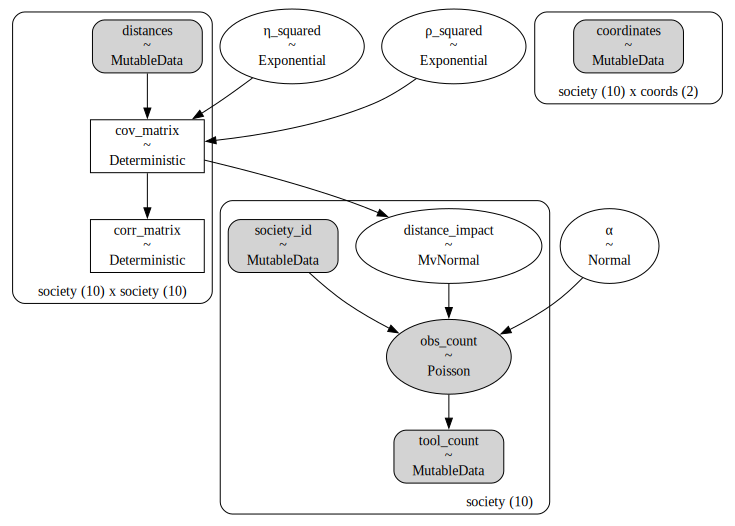

In [6]:
coords = {
    'society': societies
}

def set_data(data): 
    data['society_id'] = pm.MutableData("society_id", society_idx, dims='society')
    data['tool_count'] = pm.MutableData("tool_count", tools['total_tools'].values, dims='society')
    data['coordinates'] = pm.MutableData("coordinates", tools[['lat', 'lon2']].values, dims=['society', 'coords'])
    data['distances'] = pm.MutableData("distances", island_distances.values, dims=['society', 'society'])

def set_priors(RVs):
    RVs['α'] = pm.Normal("α", 3, 0.5)
    RVs['η'] = pm.Exponential("η_squared", 2)
    RVs['ρ'] = pm.Exponential("ρ_squared", 0.5)

def track_corr_matrix(RVs):
    stds = pm.math.sqrt(pm.math.extract_diag(RVs['cov_matrix']))
    corr_matrix = (stds ** -1) * RVs['cov_matrix'] * (stds ** -1)
    pm.Deterministic("corr_matrix", corr_matrix, dims=['society', 'society'])

def likelihood(RVs, data):
    λ = pm.math.exp(RVs['α'] + RVs['S'][data['society_id']])
    pm.Poisson('obs_count', mu=λ, observed=data['tool_count'], dims='society')


with pm.Model(coords=coords) as lecture_tools_model:
    data = {}
    RVs = {}

    #set data
    set_data(data)
    
    #priors
    set_priors(RVs=RVs)

    #Gaussian process
    RVs['cov_matrix'] = pm.Deterministic(
        "cov_matrix", 
        RVs['η'] * pm.math.exp(-RVs['ρ'] * (data['distances']) ** 2) + np.diag([0.01] * len(coords['society'])), 
        dims=['society', 'society']
    )

    RVs['S'] = pm.MvNormal("distance_impact", mu=0, cov=RVs['cov_matrix'], dims='society')
    
    #deterministic corr tracking
    track_corr_matrix(RVs)
    
    #likelihood
    likelihood(RVs, data)
    

pm.model_to_graphviz(lecture_tools_model)

In [7]:
def show_results(trace, var_names=['~distance_impact_rotated_', '~cov_matrix', '~corr_matrix']):
    display(az.summary(trace, var_names=var_names))
    az.plot_trace(trace, var_names=var_names)
    plt.tight_layout()
    plt.show()

In [8]:
with lecture_tools_model:
    lecture_tools_trace = sampling_jax.sample_blackjax_nuts()

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:01.251350
Sampling...
Sampling time =  0:00:04.354971
Transforming variables...
Transformation time =  0:00:00.689042


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.490,0.252,3.009,3.960,0.011,0.008,503.0,602.0,1.01
distance_impact[Malekula],-0.673,0.310,-1.288,-0.104,0.011,0.008,791.0,904.0,1.01
distance_impact[Tikopia],-0.428,0.297,-0.997,0.112,0.012,0.009,582.0,768.0,1.01
distance_impact[Santa Cruz],-0.375,0.305,-0.991,0.176,0.012,0.009,656.0,806.0,1.01
distance_impact[Yap],0.241,0.282,-0.288,0.767,0.012,0.008,592.0,812.0,1.01
distance_impact[Lau Fiji],0.022,0.290,-0.534,0.559,0.012,0.009,584.0,823.0,1.01
distance_impact[Trobriand],-0.472,0.298,-1.029,0.087,0.012,0.008,682.0,988.0,1.01
distance_impact[Chuuk],0.169,0.290,-0.358,0.727,0.011,0.008,652.0,805.0,1.01
distance_impact[Manus],-0.166,0.291,-0.735,0.354,0.011,0.008,680.0,914.0,1.01
distance_impact[Tonga],0.454,0.280,-0.074,0.977,0.012,0.008,593.0,825.0,1.01


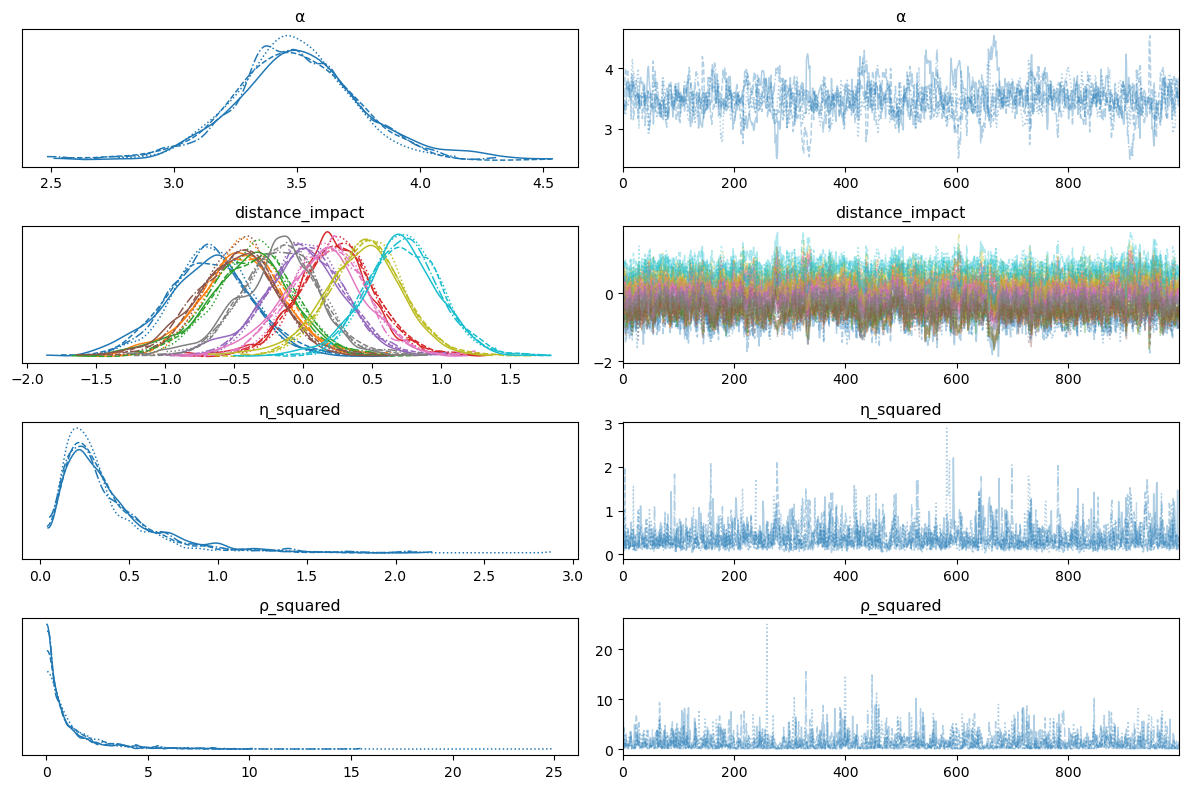

In [9]:
show_results(lecture_tools_trace, ['~cov_matrix', '~corr_matrix'])

This model samples pretty well with pyMC 5.1.2, but struggled more with previous versions. We can also try a non-centered parameterization.

## Non-centered parameterization

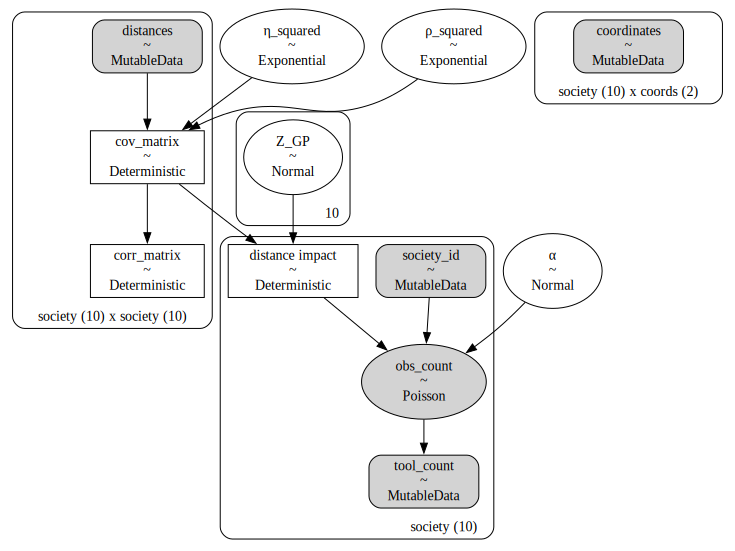

In [10]:
with pm.Model(coords=coords) as non_centered_lecture_tools_model:
    data = {}
    RVs = {}

    #set data
    set_data(data)
    
    #priors
    set_priors(RVs=RVs)

    #Gaussian process
    RVs['cov_matrix'] = pm.Deterministic(
        "cov_matrix", 
        RVs['η'] * pm.math.exp(-RVs['ρ'] * (data['distances']) ** 2) + np.diag([0.01] * len(coords['society'])), 
        dims=['society', 'society']
    )

    #implementation taken from https://www.pymc.io/projects/docs/en/stable/_modules/pymc/gp/gp.html#Latent    
    v = pm.Normal("Z_GP", mu=0.0, sigma=1.0, size=len(coords['society']))
    RVs['S'] = pm.Deterministic("distance impact", 0 + pm.gp.util.cholesky(RVs['cov_matrix']).dot(v), dims='society')
    
    #deterministic corr tracking
    track_corr_matrix(RVs)
    
    #likelihood
    likelihood(RVs, data)
    

pm.model_to_graphviz(non_centered_lecture_tools_model)

In [11]:
with non_centered_lecture_tools_model:
    non_centered_lecture_tools_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:01.098595
Sampling...
Sampling time =  0:00:04.239373
Transforming variables...
Transformation time =  0:00:00.561276


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.484,0.265,2.966,4.003,0.007,0.005,1233.0,1569.0,1.00
η_squared,0.387,0.262,0.054,0.859,0.007,0.005,1317.0,2126.0,1.00
ρ_squared,1.043,1.470,0.013,3.501,0.041,0.029,574.0,1011.0,1.01
distance impact[Malekula],-0.660,0.317,-1.233,-0.037,0.008,0.006,1548.0,2179.0,1.00
distance impact[Tikopia],-0.419,0.303,-1.007,0.139,0.008,0.005,1538.0,1996.0,1.00
distance impact[Santa Cruz],-0.375,0.314,-0.988,0.214,0.008,0.006,1567.0,2064.0,1.00
distance impact[Yap],0.247,0.297,-0.312,0.819,0.008,0.006,1283.0,1705.0,1.00
distance impact[Lau Fiji],0.029,0.299,-0.515,0.607,0.008,0.005,1471.0,1926.0,1.00
distance impact[Trobriand],-0.471,0.310,-1.062,0.113,0.008,0.005,1633.0,2016.0,1.00
distance impact[Chuuk],0.170,0.298,-0.399,0.750,0.008,0.005,1490.0,1976.0,1.00


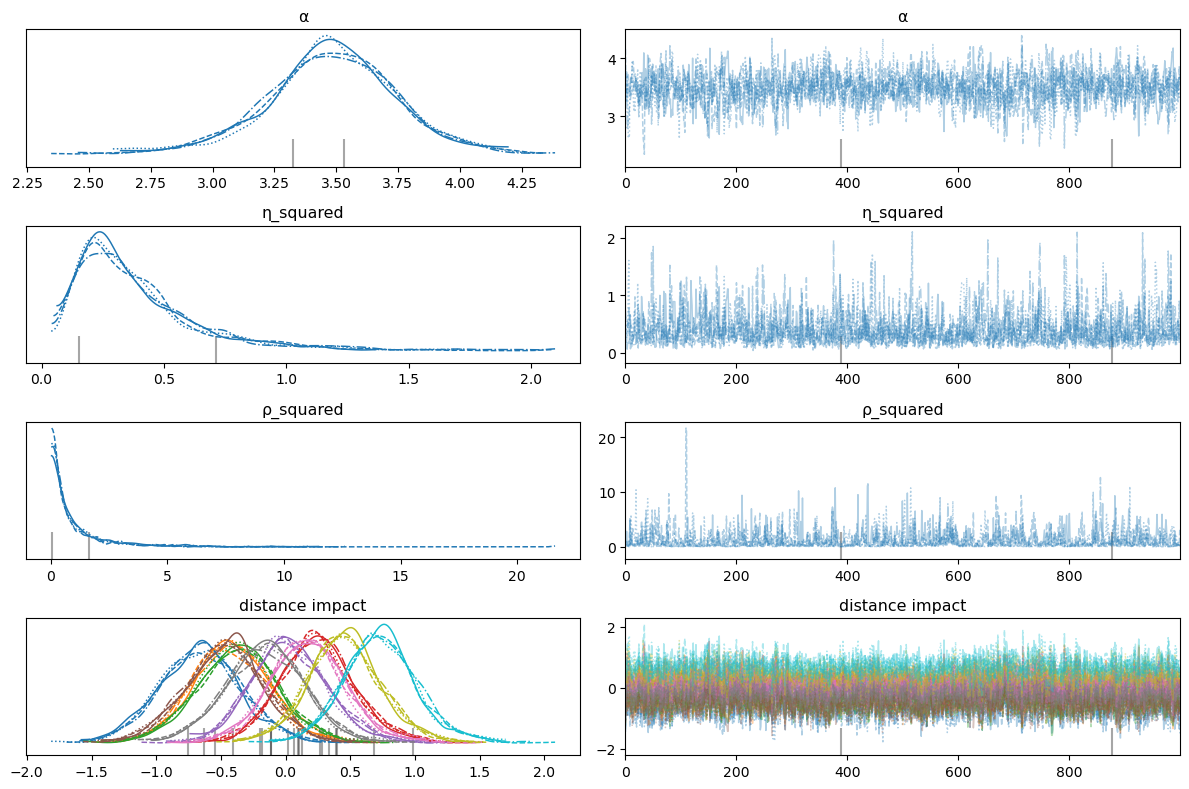

In [12]:
show_results(non_centered_lecture_tools_trace, ['~cov_matrix', '~corr_matrix', '~Z_GP'])

Let's also visualize the correlation matrix that was learned.

In [13]:
def visualize_correlation(trace):
    # adapted from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb 
    fig, ax = plt.subplots(figsize=(12, 5))

    #take the mean of the correlation matrix, element-wise
    corr_matrix_df = trace['posterior']['corr_matrix'].mean(dim=['chain', 'draw']).to_pandas().round(2)

    # overlay lines shaded by correlation
    longs = [(tools["lon2"][i], tools["lon2"][j]) for i in range(10) for j in range(i + 1, 10)]
    lats = [(tools["lat"][i], tools["lat"][j]) for i in range(10) for j in range(i + 1, 10)]
    correlations = [corr_matrix_df.iloc[i, j] for i in range(10) for j in range(i + 1, 10)]

    for lon, lat, c in zip(longs, lats, correlations):
        ax.plot(lon, lat, "k-", alpha=c, lw=2.5)

    # plot raw data and labels
    ax.scatter(tools["lon2"], tools["lat"], tools['logpop'] ** 2)

    for label, lat, lon in tools[['culture', 'lat', 'lon2']].itertuples(index=False):
        ax.text(lon + 1, lat + 1, label)

    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    plt.show()


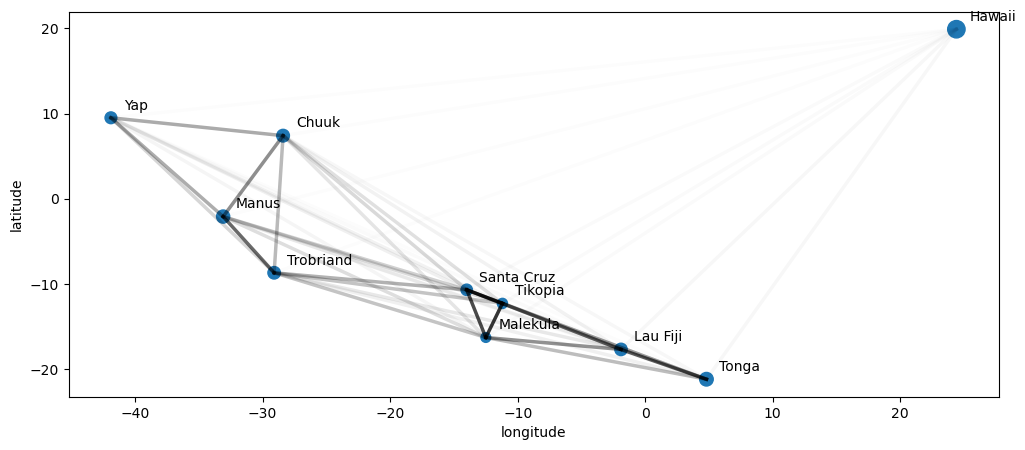

In [14]:
visualize_correlation(non_centered_lecture_tools_trace)

### Importance of taking into account parameter correlation

I computed correlation matrix by storing the covariance matrix itself in the trace. That works in this scenario, but with more data it would quickly become a memory hog. An alternative approach is to compute it from η and ρ terms in the trace as the distances themselves are static. 

If we go that route, it's important to first recreate the matrix, and only then take the mean of it vs. taking the means of ρ and η terms and using them to compute the mean matrix. That's because the two parameters are correlated.

In [15]:
#get the η and ρ parameters
η_squared = non_centered_lecture_tools_trace['posterior']['η_squared'].to_numpy().flatten()
ρ_squared = non_centered_lecture_tools_trace['posterior']['ρ_squared'].to_numpy().flatten()
l_squared = 1/ (2 * ρ_squared)

np.corrcoef(η_squared, ρ_squared)

array([[ 1.        , -0.19867072],
       [-0.19867072,  1.        ]])

Here's an incorrect way of doing it:

In [16]:
#calculate covariance matrix directly from mean values of ρ and η
cov_matrix_no_correlation = (η_squared.mean() * np.exp(np.multiply(island_distances.values, -0.5 * 1/l_squared.mean())))

#convert to correlation matrix by obtaining standard deviations & dividing
stds = np.sqrt(np.diag(cov_matrix_no_correlation))
corr_matrix_no_correlation = (stds ** -1) * cov_matrix_no_correlation * (stds**-1)

corr_matrix_df_no_correlation = pd.DataFrame(
    corr_matrix_no_correlation, 
    columns=island_distances.columns.values, 
    index=island_distances.columns.values
).round(2)

corr_matrix_df_no_correlation

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,1.00,0.89,0.85,0.34,0.74,0.60,0.45,0.50,0.63,0.24
Tikopia,0.89,1.00,0.92,0.35,0.74,0.61,0.49,0.51,0.61,0.27
Santa Cruz,0.85,0.92,1.00,0.38,0.68,0.65,0.52,0.56,0.57,0.26
Yap,0.34,0.35,0.38,1.00,0.26,0.54,0.68,0.67,0.22,0.17
Lau Fiji,0.74,0.74,0.68,0.26,1.00,0.45,0.37,0.38,0.83,0.30
Trobriand,0.60,0.61,0.65,0.54,0.45,1.00,0.64,0.81,0.38,0.19
Chuuk,0.45,0.49,0.52,0.68,0.37,0.64,1.00,0.74,0.30,0.24
Manus,0.50,0.51,0.56,0.67,0.38,0.81,0.74,1.00,0.32,0.19
Tonga,0.63,0.61,0.57,0.22,0.83,0.38,0.30,0.32,1.00,0.29
Hawaii,0.24,0.27,0.26,0.17,0.30,0.19,0.24,0.19,0.29,1.00


Comparing to the correlation matrix stored in the trace, we can see it's quite different - because it ignores correlation of the two parameters!

In [17]:
pd.DataFrame(
    non_centered_lecture_tools_trace['posterior']['corr_matrix'].mean(dim=['chain', 'draw']).to_numpy(), 
    columns=island_distances.columns.values, 
    index=island_distances.columns.values
).round(2)

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,1.00,0.79,0.71,0.04,0.43,0.23,0.10,0.13,0.26,0.02
Tikopia,0.79,1.00,0.88,0.05,0.43,0.23,0.12,0.14,0.24,0.02
Santa Cruz,0.71,0.88,1.00,0.06,0.33,0.30,0.15,0.18,0.19,0.02
Yap,0.04,0.05,0.06,1.00,0.02,0.16,0.33,0.32,0.01,0.01
Lau Fiji,0.43,0.43,0.33,0.02,1.00,0.09,0.05,0.06,0.64,0.03
Trobriand,0.23,0.23,0.30,0.16,0.09,1.00,0.27,0.59,0.06,0.01
Chuuk,0.10,0.12,0.15,0.33,0.05,0.27,1.00,0.44,0.03,0.01
Manus,0.13,0.14,0.18,0.32,0.06,0.59,0.44,1.00,0.03,0.01
Tonga,0.26,0.24,0.19,0.01,0.64,0.06,0.03,0.03,1.00,0.03
Hawaii,0.02,0.02,0.02,0.01,0.03,0.01,0.01,0.01,0.03,1.00


## Using pyMC GP functionality instead

So far, we built the GPs manually - could we use the pyMC Gaussian Process classes instead? We can, but with one caveat - pyMC GP's calculate the distance matrices internally from observation-level data. So we have to do some tweaks. We'll try two approaches:

1. We'll crudely pass covariance matrix pretending it actually is observations, and code a custom kernel that treats it that way.
2. We'll do it properly - by passing lat/lon coordinates and coding up a kernel that calculates distances from them correctly.

### The hack approach

pyMC has a `ExpQuad` [kernel](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.cov.ExpQuad.html#pymc.gp.cov.ExpQuad) that corresponds to the one used in the lecture. We'll take its code and slightly modify it.

Note that it uses a slightly different parameterization:

In rethinking: 

$$k_{i, j}=\eta^2 \exp \left(-\rho^2 d_{i, j}^2\right)$$

whereas in pyMC, the [ExpQuad kernel](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.cov.ExpQuad.html) is:

$$k\left(x, x^{\prime}\right)=\exp \left[-\frac{\left(x-x^{\prime}\right)^2}{2 \ell^2}\right]$$

So the $\eta^2$ term is something we'll add on top, whereas $\ell$ and $\rho$ share the following relationship:

$$ \rho^2 = \frac{1}{2 \ell^2}$$
$$ \ell^2 = \frac{1}{2 \rho^2}$$



In [18]:
class ExpQuadHack(pm.gp.cov.Stationary):
    def full(self, X, Xs=None):        
        return pt.tensor.exp(-0.5 * (X ** 2) / self.ls)

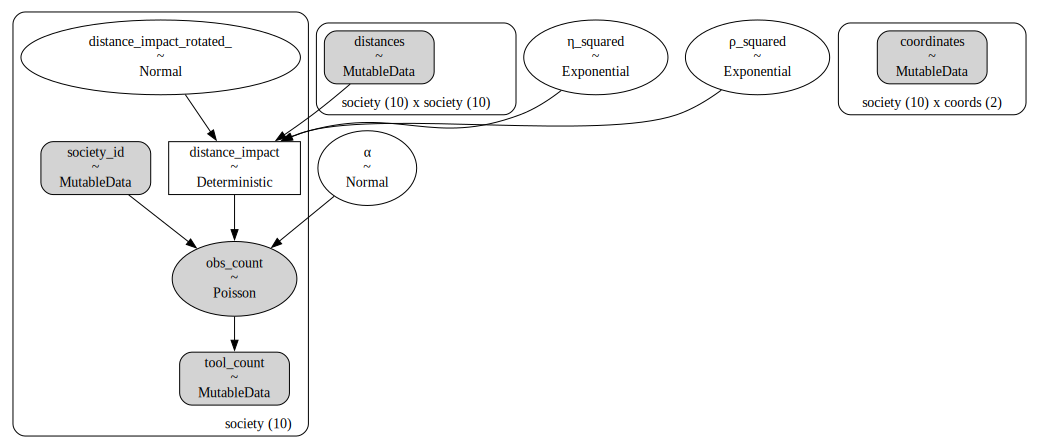

In [19]:
with pm.Model(coords=coords) as pymc_hack_model:
    data = {}
    RVs = {}

    #set data
    set_data(data)
    
    #priors
    set_priors(RVs=RVs)
    ls = 1 / (2 * RVs['ρ'])

    #Gaussian process
    cov_func = RVs['η'] * ExpQuadHack(input_dim=10, ls=ls) + pm.gp.cov.WhiteNoise(0.01) #for numerical stability
    gp = pm.gp.Latent(cov_func=cov_func)

    RVs['S'] = gp.prior("distance_impact", X=data['distances'], dims='society')
    
    #likelihood
    likelihood(RVs, data)
    

pm.model_to_graphviz(pymc_hack_model)

Compiling...
Compilation time =  0:00:01.717092
Sampling...
Sampling time =  0:00:04.235967
Transforming variables...
Transformation time =  0:00:00.506664


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.487,0.252,3.015,3.962,0.007,0.005,1363.0,1012.0,1.00
η_squared,0.377,0.247,0.069,0.817,0.008,0.005,1178.0,1457.0,1.00
ρ_squared,1.136,1.386,0.027,3.528,0.042,0.030,608.0,1178.0,1.01
distance_impact[Malekula],-0.654,0.313,-1.254,-0.070,0.008,0.005,1696.0,1312.0,1.00
distance_impact[Tikopia],-0.428,0.295,-0.980,0.134,0.007,0.005,1632.0,1457.0,1.00
distance_impact[Santa Cruz],-0.380,0.300,-0.928,0.190,0.008,0.005,1520.0,2011.0,1.00
distance_impact[Yap],0.244,0.281,-0.299,0.744,0.007,0.006,1545.0,1341.0,1.00
distance_impact[Lau Fiji],0.033,0.288,-0.508,0.556,0.007,0.006,1722.0,1261.0,1.00
distance_impact[Trobriand],-0.472,0.293,-1.031,0.067,0.007,0.005,1708.0,2189.0,1.00
distance_impact[Chuuk],0.172,0.288,-0.370,0.706,0.007,0.006,1607.0,1533.0,1.00


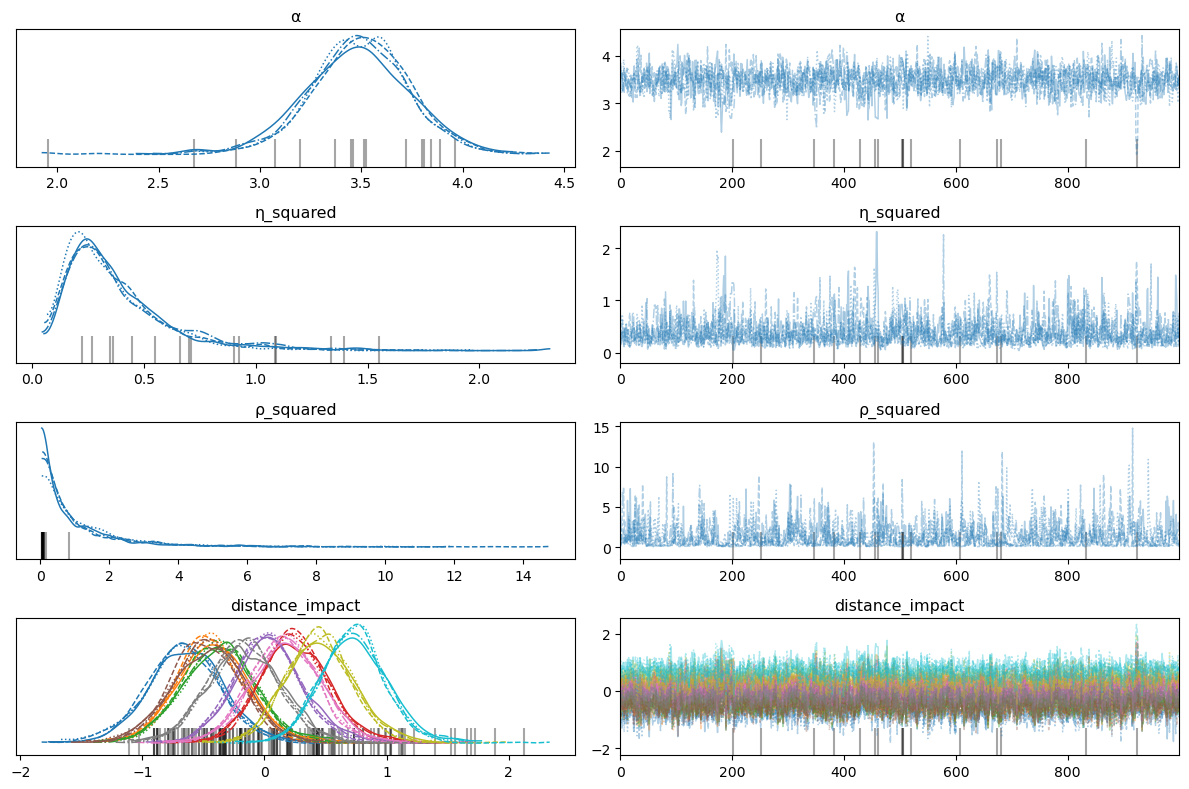

In [20]:
with pymc_hack_model:
    pymc_hack_trace = sampling_jax.sample_blackjax_nuts()

show_results(pymc_hack_trace, ['~distance_impact_rotated_'])

This approach works - but it would be a pain if we wanted to leverage other pyMC GP features, such as getting GP evaluated at another point (imagine if we wanted to learn the impact of another Pacific island that was not in the initial training set). So it really should only be used when you don't care about other features or have a very special distance matrix that has a very complex distance function which is hard to express in pyMC.

In this case, we can code up a distance function and use lat/lon coordinates to let pyMC calculate it for us. Then, we will be able to leverage it for predictions and other methods. PyMC labs has a [post on the topic of Gaussian processes and spatial distances](https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/) from which I took some of the code below for the Chordal distance implementation.

In [21]:
#Chordal distance - taken from https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/ with modifications
class ExpQuadChordal(pm.gp.cov.ExpQuad):
    def __init__(self, input_dim, ls, r=6378.137, active_dims=None):
        if input_dim != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dim, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = np.deg2rad(lonlat)
        return self.r * pt.tensor.stack(
            [
                pt.tensor.cos(lonlat[..., 0]) * pt.tensor.cos(lonlat[..., 1]),
                pt.tensor.sin(lonlat[..., 0]) * pt.tensor.cos(lonlat[..., 1]),
                pt.tensor.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def squared_chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X, Xs = pt.tensor.extra_ops.broadcast_arrays(
            self.lonlat2xyz(X[..., :, None, :]), self.lonlat2xyz(Xs[..., None, :, :])
        )
        return pt.tensor.sum((X - Xs) ** 2, axis=-1)    
    
    def chordal_dist(self, X, Xs=None):
        return pt.tensor.sqrt(self.squared_chordal_dist(X, Xs) + 1e-12)
    
    def full(self, X, Xs=None):        
        X, Xs = self._slice(X, Xs)
        return pt.tensor.exp(-0.5 * self.squared_chordal_dist(X, Xs) / self.ls)        

We can compare how different are the chordal distances from the ones provided in the rethinking package. It seems that the errors are below 5% - probably good enough!

In [22]:
kernel = ExpQuadChordal(2, 1)
x = pt.tensor.matrix()
z = kernel.chordal_dist(x)
D = z.eval({x: np.array(tools[['lat', 'lon2']].values)})

pd.DataFrame(np.abs((D / 1000 - island_distances.values)) / (island_distances.values)).round(3)

/tmp/ipykernel_24727/2500760787.py:6: RuntimeWarning: divide by zero encountered in divide
  pd.DataFrame(np.abs((D / 1000 - island_distances.values)) / (island_distances.values)).round(3)


,0,1,2,3,4,5,6,7,8,9
0,inf,0.034,0.003,0.073,0.037,0.018,0.056,0.037,0.071,0.031
1,0.034,inf,0.133,0.052,0.035,0.006,0.033,0.014,0.032,0.028
2,0.003,0.133,inf,0.063,0.001,0.011,0.054,0.030,0.044,0.027
3,0.073,0.052,0.063,inf,0.059,0.122,0.028,0.126,0.049,0.019
4,0.037,0.035,0.001,0.059,inf,0.024,0.029,0.033,0.102,0.001
5,0.018,0.006,0.011,0.122,0.024,inf,0.129,0.094,0.012,0.039
6,0.056,0.033,0.054,0.028,0.029,0.129,inf,0.137,0.021,0.003
7,0.037,0.014,0.030,0.126,0.033,0.094,0.137,inf,0.011,0.034
8,0.071,0.032,0.044,0.049,0.102,0.012,0.021,0.011,inf,0.050
9,0.031,0.028,0.027,0.019,0.001,0.039,0.003,0.034,0.050,inf


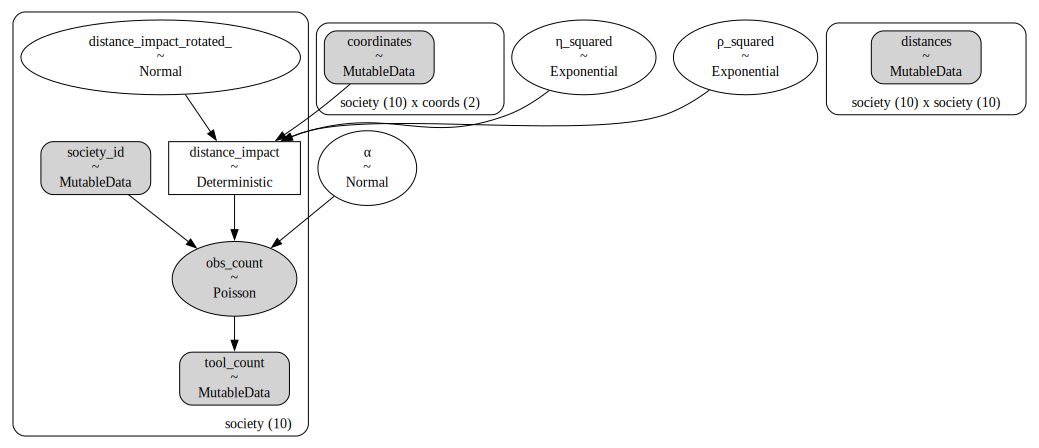

In [23]:
with pm.Model(coords=coords) as pymc_chordal_model:
    data = {}
    RVs = {}

    #set data
    set_data(data)
    
    #priors
    set_priors(RVs=RVs)
    ls = 1 / (2 * RVs['ρ'])

    #Gaussian process
    cov_func = RVs['η'] * ExpQuadChordal(input_dim=2, ls=ls) + pm.gp.cov.WhiteNoise(0.01)
    gp = pm.gp.Latent(cov_func=cov_func)

    RVs['S'] = gp.prior("distance_impact", X=data['coordinates'], dims='society')
    
    #likelihood
    likelihood(RVs, data)
    

pm.model_to_graphviz(pymc_chordal_model)

Interestingly, we get similar results for all parameters except ρ, which is now 2x the previous value. I thought I made a parameterization mistake, but it does not seem so..

Compiling...
Compilation time =  0:00:02.888394
Sampling...
Sampling time =  0:00:04.718500
Transforming variables...
Transformation time =  0:00:00.400811


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.398,0.182,3.029,3.722,0.006,0.004,829.0,1286.0,1.0
η_squared,0.321,0.180,0.074,0.619,0.006,0.004,954.0,1570.0,1.0
ρ_squared,1.974,1.971,0.000,5.513,0.031,0.024,2539.0,1886.0,1.0
distance_impact[Malekula],-0.674,0.281,-1.188,-0.152,0.007,0.005,1788.0,2037.0,1.0
distance_impact[Tikopia],-0.277,0.251,-0.768,0.168,0.006,0.005,1531.0,2074.0,1.0
distance_impact[Santa Cruz],-0.204,0.250,-0.678,0.264,0.007,0.005,1479.0,2237.0,1.0
distance_impact[Yap],0.320,0.223,-0.098,0.736,0.006,0.004,1407.0,2150.0,1.0
distance_impact[Lau Fiji],0.078,0.229,-0.365,0.499,0.006,0.004,1372.0,2264.0,1.0
distance_impact[Trobriand],-0.395,0.261,-0.940,0.053,0.006,0.004,1789.0,2174.0,1.0
distance_impact[Chuuk],0.253,0.229,-0.214,0.655,0.006,0.005,1275.0,1969.0,1.0


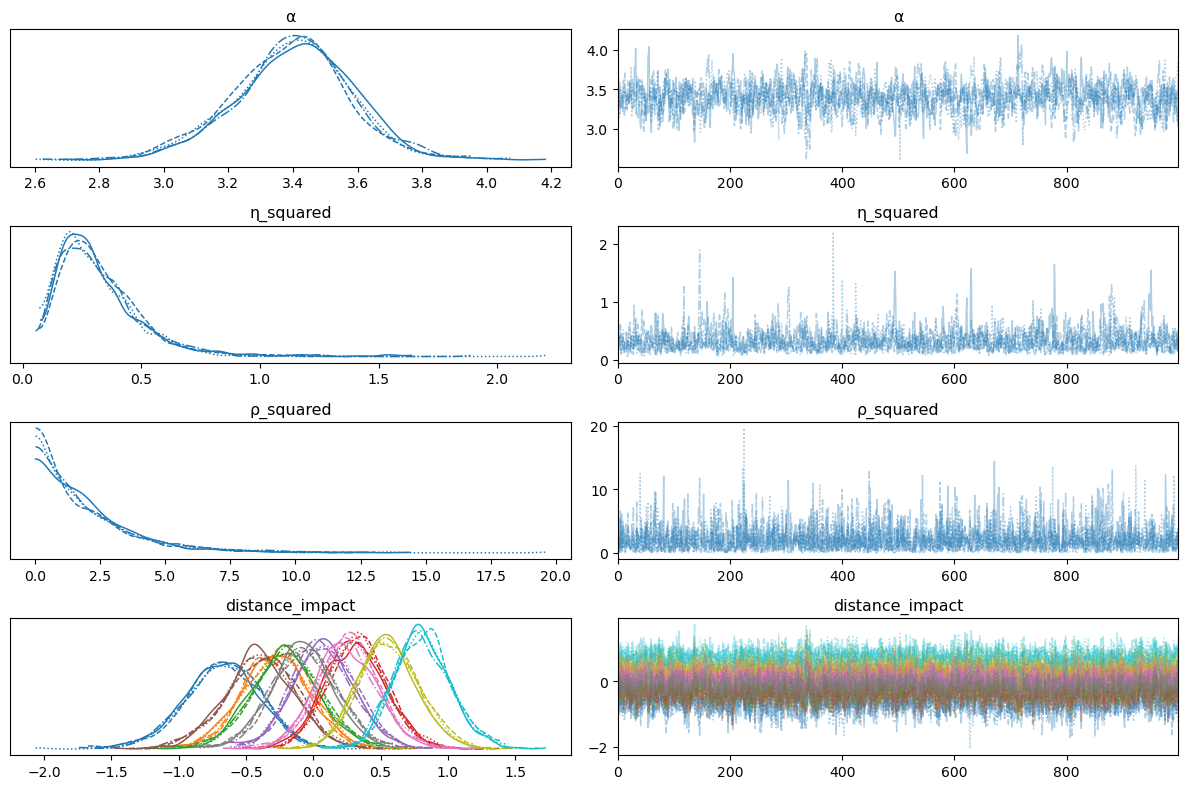

In [24]:
with pymc_chordal_model:
    pymc_chordal_trace = sampling_jax.sample_blackjax_nuts()    

show_results(pymc_chordal_trace, ['~distance_impact_rotated_'])

## Tools model stratified by population size

Finally, we can build the model that also incorporates population size. To be as close to the lecture examples as possible, I will use the "pyMC hack" approach.

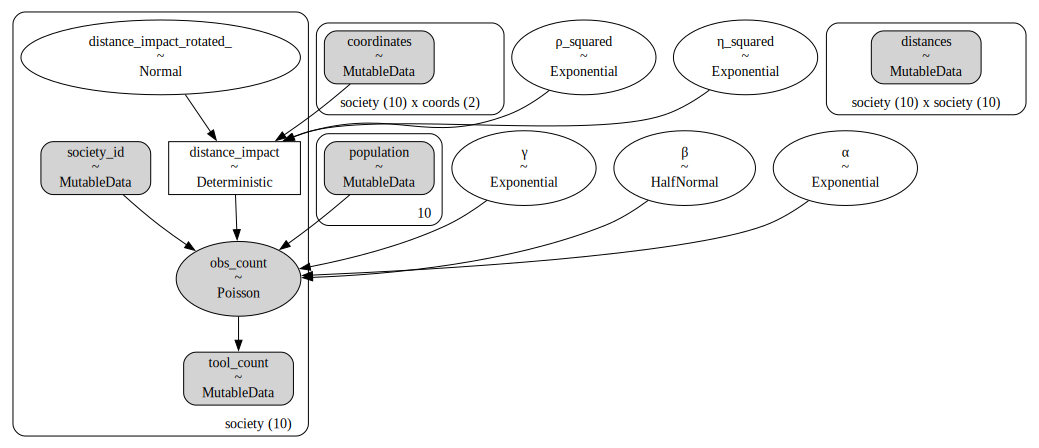

In [25]:
with pm.Model(coords=coords) as pop_model:
    data = {}
    RVs = {}

    #set data
    set_data(data)
    population = pm.MutableData("population", tools['population'])
    
    #priors    
    RVs['η'] = pm.Exponential("η_squared", 2)
    RVs['ρ'] = pm.Exponential("ρ_squared", 0.5)
    α = pm.Exponential("α", 1)
    #β = pm.Exponential("β", 1)
    β = pm.HalfNormal("β", 0.5) #need a tighter prior for this one 
    γ = pm.Exponential("γ", 1)
    ls = 1 / (2 * RVs['ρ'])

    #Gaussian process
    cov_func = RVs['η'] * ExpQuadChordal(input_dim=2, ls=ls) + pm.gp.cov.WhiteNoise(0.01)
    gp = pm.gp.Latent(cov_func=cov_func)

    RVs['S'] = gp.prior("distance_impact", X=data['coordinates'], dims='society')

    #cov_func = RVs['η'] * ExpQuadHack(input_dim=10, ls=ls) + pm.gp.cov.WhiteNoise(0.01) #for numerical stability
    #gp = pm.gp.Latent(cov_func=cov_func)

    #RVs['S'] = gp.prior("distance_impact", X=data['distances'], dims='society')
    
    #likelihood
    λ = pm.math.exp(RVs['S'][data['society_id']]) * (α * (population ** β)) / γ
    pm.Poisson('obs_count', mu=λ, observed=data['tool_count'], dims='society')
    
pm.model_to_graphviz(pop_model)


In [26]:
with pop_model:
    pop_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:03.121186
Sampling...
Sampling time =  0:00:05.823803
Transforming variables...
Transformation time =  0:00:02.428210


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
η_squared,0.127,0.101,0.004,0.292,0.003,0.002,1256.0,2042.0,1.0
ρ_squared,1.990,1.963,0.002,5.549,0.029,0.022,2884.0,1627.0,1.0
α,1.369,1.035,0.044,3.291,0.018,0.013,2296.0,1853.0,1.0
β,0.281,0.074,0.152,0.434,0.002,0.001,1612.0,1454.0,1.0
γ,0.609,0.560,0.008,1.573,0.011,0.008,1858.0,1584.0,1.0
distance_impact[Malekula],-0.183,0.238,-0.641,0.253,0.005,0.003,2791.0,3135.0,1.0
distance_impact[Tikopia],0.082,0.221,-0.353,0.492,0.005,0.003,2320.0,2667.0,1.0
distance_impact[Santa Cruz],-0.022,0.201,-0.378,0.362,0.004,0.003,2928.0,2782.0,1.0
distance_impact[Yap],0.361,0.196,-0.008,0.712,0.004,0.003,2594.0,2500.0,1.0
distance_impact[Lau Fiji],0.060,0.184,-0.292,0.393,0.003,0.002,3093.0,3115.0,1.0


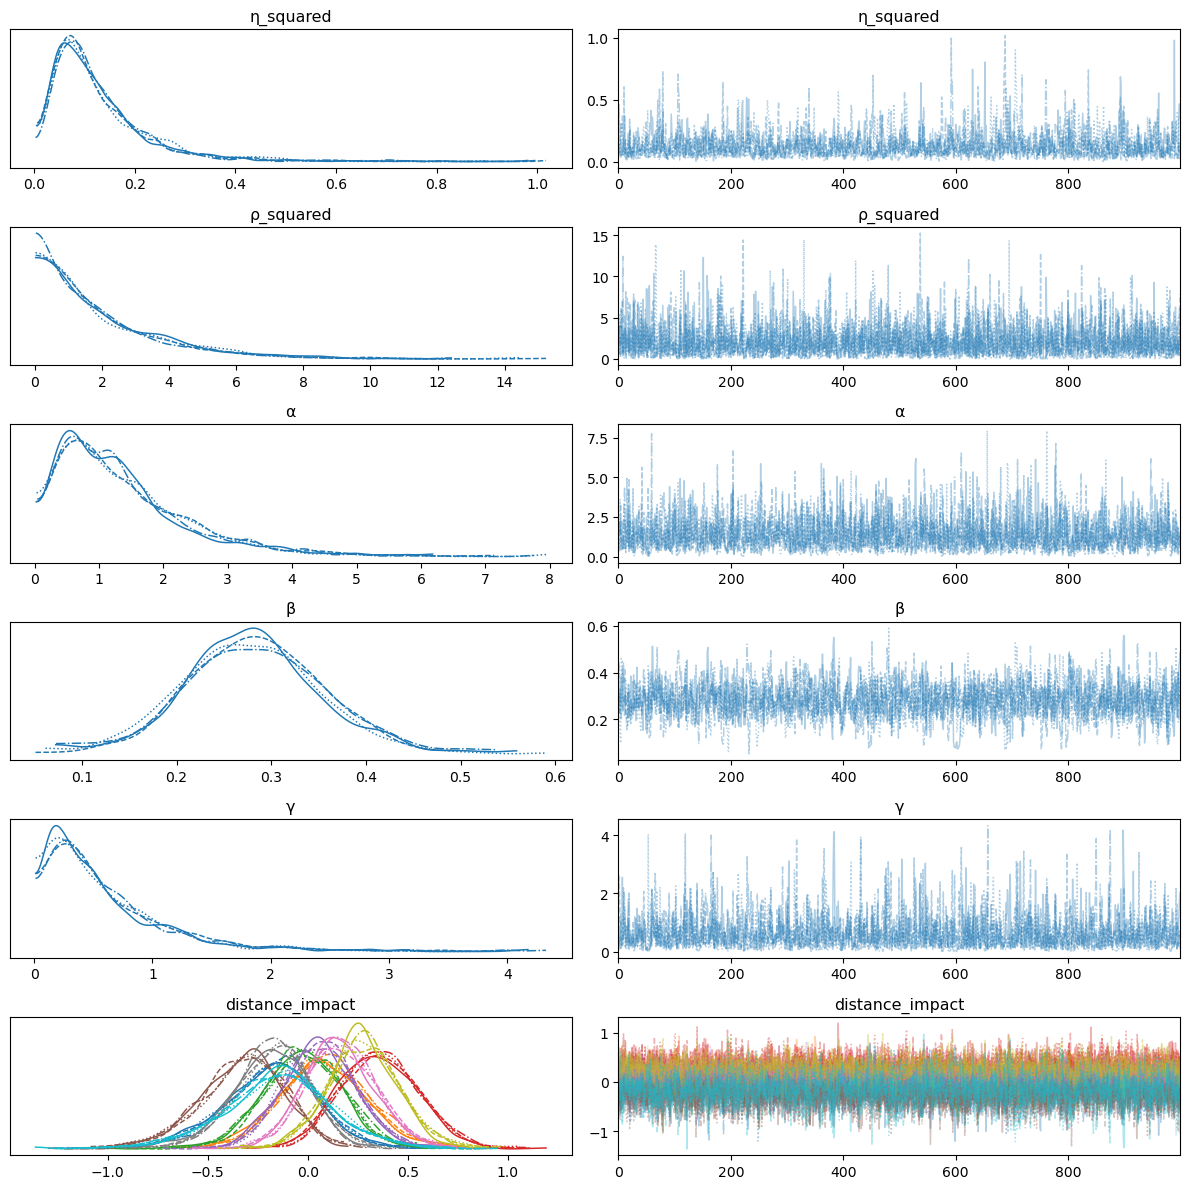

In [27]:
show_results(pop_trace, var_names=['~distance_impact_rotated_'])